# Setup

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import fiona

pd.options.display.max_columns = None 

# set working directory
os.chdir('/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/Data')

import warnings
from sklearn.exceptions import ConvergenceWarning

# Ignore convergence warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [2]:
# Load Data
no_spills = gpd.read_file('no_spills_cleaned.geojson')
spills = gpd.read_file('spills_cleaned.geojson')

In [3]:
print(no_spills.info())
print(no_spills.shape)

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 4116 entries, 0 to 4115
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   operator_number         4116 non-null   int64   
 1   flowline_id             4116 non-null   float64 
 2   location_id             4116 non-null   float64 
 3   status                  4116 non-null   object  
 4   flowline_action         4116 non-null   object  
 5   location_type           4116 non-null   object  
 6   fluid                   4116 non-null   object  
 7   material                4116 non-null   object  
 8   diameter_in             4116 non-null   int64   
 9   length_ft               4116 non-null   int64   
 10  max_operating_pressure  4116 non-null   int64   
 11  shape_length            4116 non-null   int64   
 12  line_age_yr             4116 non-null   int64   
 13  risk                    4116 non-null   int64   
 14  geometry        

In [4]:
print(spills.info())
print(spills.shape)

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   operator_number         40 non-null     int64   
 1   flowline_id             40 non-null     float64 
 2   location_id             40 non-null     float64 
 3   status                  40 non-null     object  
 4   flowline_action         40 non-null     object  
 5   location_type           40 non-null     object  
 6   fluid                   40 non-null     object  
 7   material                40 non-null     object  
 8   diameter_in             40 non-null     int64   
 9   length_ft               40 non-null     int64   
 10  max_operating_pressure  40 non-null     int64   
 11  shape_length            40 non-null     int64   
 12  line_age_yr             40 non-null     int64   
 13  root_cause_type         40 non-null     object  
 14  risk                

In [5]:
# Combine both datasets
complete_data = pd.concat([no_spills,spills],ignore_index=True)

In [6]:
print(complete_data.info())
print(complete_data.shape)

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 4156 entries, 0 to 4155
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   operator_number         4156 non-null   int64   
 1   flowline_id             4156 non-null   float64 
 2   location_id             4156 non-null   float64 
 3   status                  4156 non-null   object  
 4   flowline_action         4156 non-null   object  
 5   location_type           4156 non-null   object  
 6   fluid                   4156 non-null   object  
 7   material                4156 non-null   object  
 8   diameter_in             4156 non-null   int64   
 9   length_ft               4156 non-null   int64   
 10  max_operating_pressure  4156 non-null   int64   
 11  shape_length            4156 non-null   int64   
 12  line_age_yr             4156 non-null   int64   
 13  risk                    4156 non-null   int64   
 14  geometry        

### Match Operator Number to Operator Name

For future reference

In [7]:
# Load operator_mapping.csv
operator_mapping = pd.read_csv('operator_mapping.csv')
operator_mapping.rename(columns={'OPERATOR_NUM': 'operator_number'}, inplace=True)

# Extract unique operator_number values from complete_data
unique_operator_nums_complete_data = complete_data['operator_number'].unique()

# Filter the operator_mapping to keep only rows with operator numbers present in complete_data
filtered_operator_mapping = operator_mapping[operator_mapping['operator_number'].isin(unique_operator_nums_complete_data)].drop_duplicates().reset_index(drop=True)

# Display the filtered DataFrame
print(filtered_operator_mapping.to_string(index=False))

 operator_number                              operator_name
             710                           AEON ENERGY CORP
            3250                ANTELOPE ENERGY COMPANY LLC
            6720              ROBERT L BAYLESS PRODUCER LLC
            7125                       BEEMAN OIL & GAS LLC
            7800                          BEREN CORPORATION
            8960 BONANZA CREEK ENERGY OPERATING COMPANY LLC
           10000              BP AMERICA PRODUCTION COMPANY
           10017                       CHACO ENERGY COMPANY
           10071            HIGHPOINT OPERATING CORPORATION
           10085                        ARMOR PETROLEUM INC
           10110        GREAT WESTERN OPERATING COMPANY LLC
           10112           FOUNDATION ENERGY MANAGEMENT LLC
           10133                     HILCORP ENERGY COMPANY
           10261     BAYSWATER EXPLORATION & PRODUCTION LLC
           10299           KUENZLER & FLORA RESERVE COMPANY
           10312                        

In [8]:
unique_operator_nums = complete_data['operator_number'].unique()
print(unique_operator_nums.shape)
print(filtered_operator_mapping.shape)

(88,)
(89, 2)


In [9]:
# Check for duplicate operator numbers
duplicates = filtered_operator_mapping.duplicated(subset='operator_number', keep=False)

# Filter out the rows where operator number is duplicated
duplicate_rows = filtered_operator_mapping[duplicates]
duplicate_rows

,operator_number,operator_name
25,10531,GRIZZLY OPERATING LLC
26,10531,VANGUARD OPERATING LLC


In [10]:
# Save the resulting DataFrame to a CSV file
filtered_operator_mapping.to_csv('filtered_operator_mapping.csv', index=False)

# Exploratory Analysis

## Spatial Distribution

/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


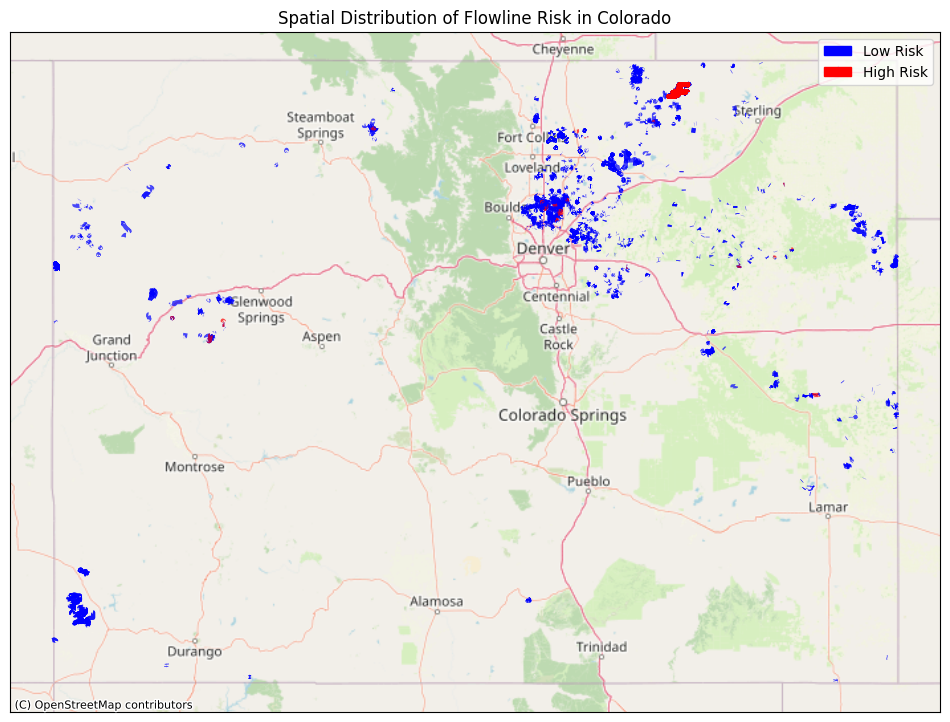

In [11]:
import contextily as ctx
from matplotlib.colors import ListedColormap, Normalize
import matplotlib.patches as mpatches

# Convert CRS to EPSG:3857 for contextily base map
complete_data_wm = complete_data.to_crs(epsg=3857)

# Define custom colors and normalization
cmap = ListedColormap(['blue', 'red'])
norm = Normalize(vmin=0, vmax=1)

# Sort the data by risk level, assuming higher risk has higher numerical value
complete_data_wm = complete_data_wm.sort_values(by='risk')

# Plotting
fig, ax = plt.subplots(figsize=(12, 12))  # Increased plot size
complete_data_wm.plot(column='risk', ax=ax, cmap=cmap, norm=norm, alpha=0.7, linewidth=3)  # Increased line width for better visibility

# Add base map
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# Create custom legend
low_risk_patch = mpatches.Patch(color='blue', label='Low Risk')
high_risk_patch = mpatches.Patch(color='red', label='High Risk')
plt.legend(handles=[low_risk_patch, high_risk_patch], loc='upper right')

ax.set_title('Spatial Distribution of Flowline Risk in Colorado')
ax.set_xticks([])  # Remove x ticks for cleaner look
ax.set_yticks([])  # Remove y ticks

plt.show()

## Risk Frequency Graphs

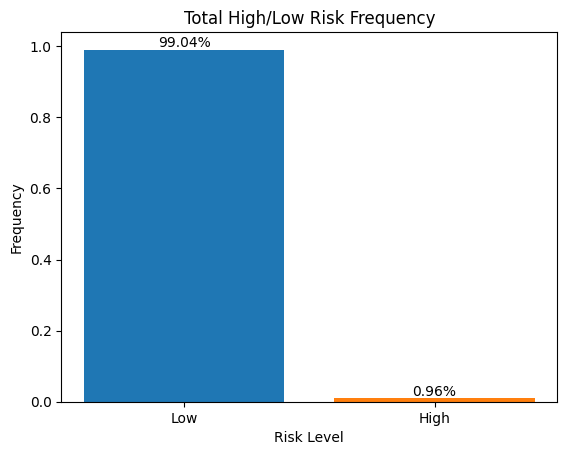

In [12]:
# Calculate total number of instances
total_instances = len(complete_data)

# Calculate frequencies of low and high risk
low_risk_frequency = (complete_data['risk'] == 0).sum() / total_instances
high_risk_frequency = (complete_data['risk'] == 1).sum() / total_instances

# Plot frequency map
bars = plt.bar(['Low', 'High'], [low_risk_frequency, high_risk_frequency], color=['#1f77b4', '#ff7f0e'])
plt.xlabel('Risk Level')
plt.ylabel('Frequency')
plt.title('Total High/Low Risk Frequency')

# Add percentages above each bar
for bar, percentage in zip(bars, [low_risk_frequency, high_risk_frequency]):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{percentage:.2%}', ha='center', va='bottom')

plt.show()

This operation filters the dataset to include only those parameters that have at least one instance of high risk (risk = 1). It then compares the frequency of these parameters when the risk is 0 versus when the risk is 1. The result is a series of bar plots showing how often each parameter occurs at different risk levels.

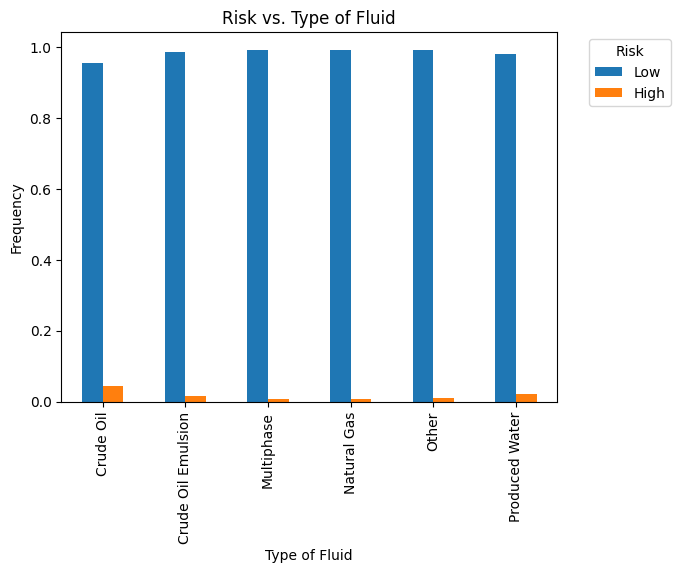

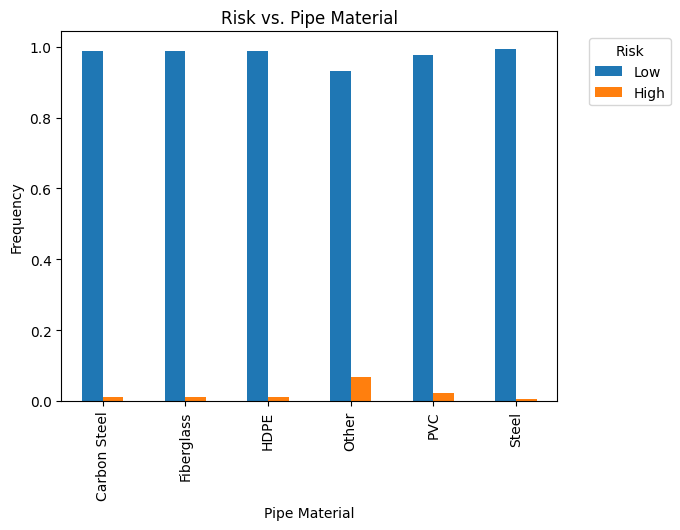

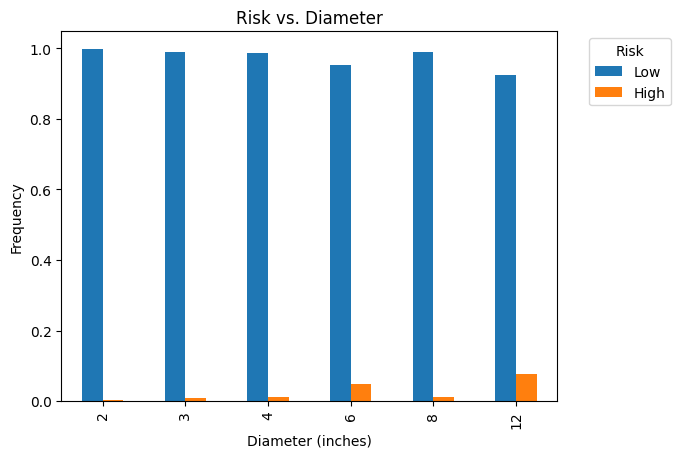

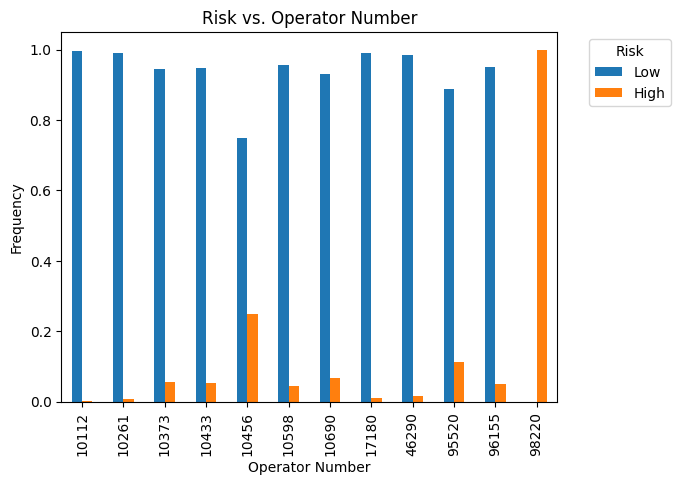

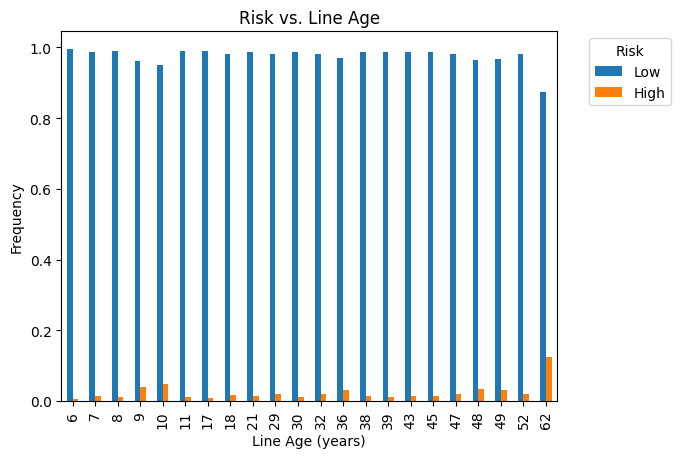

In [13]:
def plot_risk_vs_parameter(data, parameter, title, xlabel, ylabel):
    # Filter data to include only parameters that have a risk of 1
    risk_1_data = data[data['risk'] == 1][parameter].unique()
    filtered_data = data[data[parameter].isin(risk_1_data)]
    
    # Group by the parameter and risk, then calculate the size
    counts = filtered_data.groupby([parameter, 'risk']).size().reset_index(name='counts')
    pivot_counts = counts.pivot(index=parameter, columns='risk', values='counts').fillna(0)
    
    # Calculate the frequencies
    pivot_counts = pivot_counts.div(pivot_counts.sum(axis=1), axis=0)
    
    # Plot the frequencies
    pivot_counts.plot(kind='bar', stacked=False)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend(['Low', 'High'], title='Risk', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

# Example usage with complete_data
# 1. Risk vs. Type of Fluid
plot_risk_vs_parameter(complete_data, 'fluid', 'Risk vs. Type of Fluid', 'Type of Fluid', 'Frequency')

# 2. Risk vs. Pipe Material
plot_risk_vs_parameter(complete_data, 'material', 'Risk vs. Pipe Material', 'Pipe Material', 'Frequency')

# 3. Risk vs. Diameter
plot_risk_vs_parameter(complete_data, 'diameter_in', 'Risk vs. Diameter', 'Diameter (inches)', 'Frequency') 

# 4. Risk vs. Operator Number 
plot_risk_vs_parameter(complete_data, 'operator_number', 'Risk vs. Operator Number', 'Operator Number', 'Frequency') 

# 5. Risk vs. Line Age 
plot_risk_vs_parameter(complete_data, 'line_age_yr', 'Risk vs. Line Age', 'Line Age (years)', 'Frequency') 

# ML Models (with Full Dataset)

## Setup

### One hot encoding

Turning text columns into numbers

Ordinal Data: If the categories have a meaningful order or rank, they are ordinal. In such cases, assigning numbers like 1-5 makes sense as the numerical order reflects the order of the categories. For example, ratings from 'Very Poor' to 'Excellent' could be encoded as 1 through 5.

Nominal Data: If the categories do not have an inherent order, they are nominal. For such data, using numeric encoding (like 1, 2, 3, etc.) can inadvertently imply a hierarchy or order that doesn't actually exist, which might lead to misleading results in your model. Instead, you should use one-hot encoding (also known as dummy variables).

In [14]:
complete_data_transformed = pd.get_dummies(complete_data, columns=['operator_number', 'flowline_id', 'location_id', 'status', 'flowline_action', 'location_type', 'fluid', 'material', 'root_cause_type'], drop_first=True)

# List of original columns that are not one-hot encoded
original_columns = no_spills.columns.tolist()

# List of new columns that are the result of get_dummies
new_dummy_columns = [col for col in complete_data_transformed.columns if col not in original_columns]

# Convert only the dummy columns to int
complete_data_transformed[new_dummy_columns] = complete_data_transformed[new_dummy_columns].astype(int)

In [15]:
print(complete_data_transformed.info())
print(complete_data_transformed.shape)

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 4156 entries, 0 to 4155
Columns: 4965 entries, diameter_in to root_cause_type_Unknown
dtypes: geometry(1), int64(4964)
memory usage: 157.4 MB
None
(4156, 4965)


### Train/Test Spilt

In [16]:
# Extract inputs and target from the GeoDataFrame
inputs = complete_data_transformed.drop(columns=['risk', 'geometry'])  # Drop 'risk' and 'geometry' columns
target = complete_data_transformed['risk']

from sklearn.model_selection import train_test_split

trainX, testX, trainY, testY = train_test_split(inputs, target, test_size = 0.3)

X = np.asarray(trainX)
y = np.asarray(trainY)
testX = np.asarray(testX)
testY = np.asarray(testY)

## Single Classifiers

### 1-Logistic Regression

Accuracy:  0.9863672814755413
F1 Scores:  [0.         0.2        0.         0.16666667 0.        ]
F1 Scores Mean 0.07333333333333333
F1 Scores STD:  0.09043106644167025


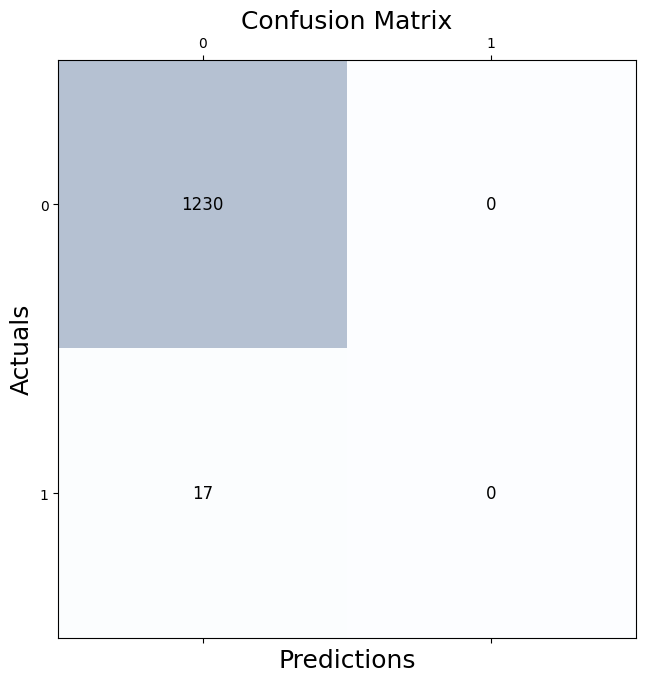

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1230
           1       0.00      0.00      0.00        17

    accuracy                           0.99      1247
   macro avg       0.49      0.50      0.50      1247
weighted avg       0.97      0.99      0.98      1247



/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to cont

In [17]:
import sklearn as sk
from sklearn import metrics
from sklearn.metrics import confusion_matrix, f1_score, classification_report, make_scorer
from sklearn import model_selection
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn import linear_model

#create a model object
model = linear_model.LogisticRegression()
model.fit(X, y)

#train the model
y_hat = model.predict(testX)

#evaluate the model
accuracy = model.score(testX, testY)
print('Accuracy: ', accuracy)

#setup to get f-score and cross validation
scorerVar = make_scorer(f1_score, pos_label=1)

scores = cross_val_score(model, inputs, target, cv = StratifiedKFold(n_splits=5, shuffle=True), scoring=scorerVar)
print('F1 Scores: ', scores)
print('F1 Scores Mean', scores.mean())
print('F1 Scores STD: ', scores.std())

#confusion matrix
conf_matrix = sk.metrics.confusion_matrix(testY, model.predict(testX))
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

#classification report
print(classification_report(testY, model.predict(testX)))

### 2-K-Nearest Neigbor

0.9863672814755413
[0.42857143 0.33333333 0.22222222 0.         0.4       ]
0.2768253968253968
0.15556721692603284


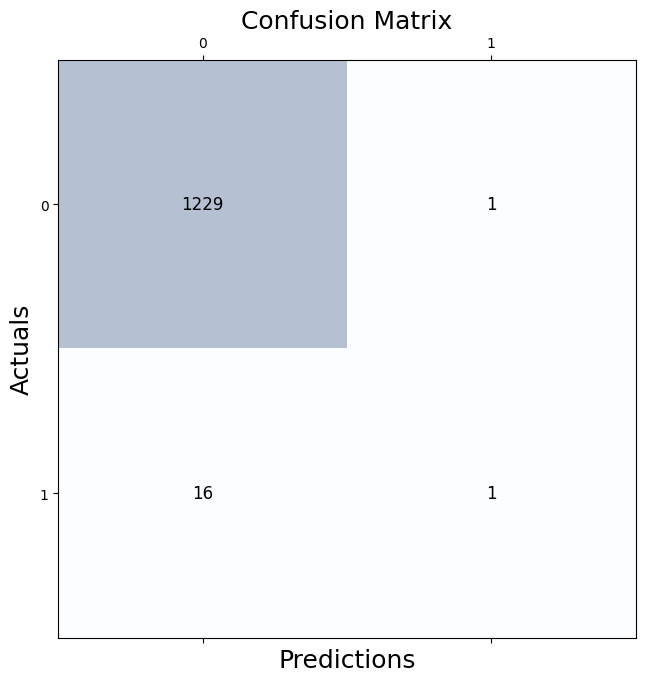

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1230
           1       0.50      0.06      0.11        17

    accuracy                           0.99      1247
   macro avg       0.74      0.53      0.55      1247
weighted avg       0.98      0.99      0.98      1247



In [18]:
from sklearn import neighbors
from sklearn.neighbors import KNeighborsClassifier

k = 5
model = neighbors.KNeighborsClassifier(k)
model.fit(X,y)

y_hat = model.predict(testX)

accuracy = model.score(testX, testY)
print(accuracy)

#Cross Validation
scorerVar = make_scorer(f1_score, pos_label=1)

scores = cross_val_score(model, inputs, target, cv = StratifiedKFold(n_splits=5, shuffle=True), scoring=scorerVar)
print(scores)
print(scores.mean())
print(scores.std())

#Confusion Matrix
conf_matrix = sk.metrics.confusion_matrix(testY, model.predict(testX))
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

#Classification Report
print(classification_report(testY, model.predict(testX)))

### 3-Support Vector Machine

Accuracy:  0.9863672814755413
F1 Scores:  [0. 0. 0. 0. 0.]
F1 Scores Mean 0.0
F1 Scores STD:  0.0


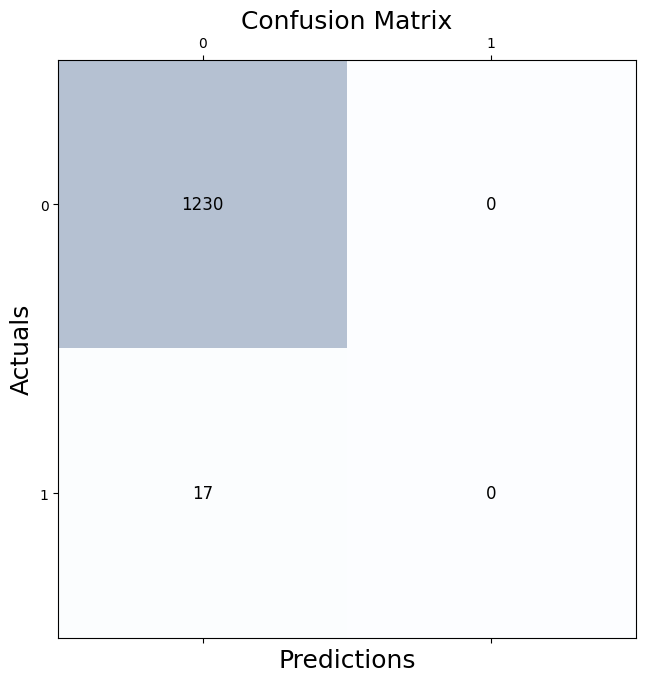

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1230
           1       0.00      0.00      0.00        17

    accuracy                           0.99      1247
   macro avg       0.49      0.50      0.50      1247
weighted avg       0.97      0.99      0.98      1247



/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to cont

In [19]:
from sklearn import svm
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

#create a model object

model = svm.SVC(kernel='rbf', C=10)
model.fit(X, y)

#train our model
y_hat = model.predict(testX)


#evaluate the model
accuracy = model.score(testX, testY)
print('Accuracy: ', accuracy)

#setup to get f-score and cv
scorerVar = make_scorer(f1_score, pos_label=1)

scores = cross_val_score(model, inputs, target, cv = StratifiedKFold(n_splits=5, shuffle=True), scoring=scorerVar)
print('F1 Scores: ', scores)
print('F1 Scores Mean', scores.mean())
print('F1 Scores STD: ', scores.std())

#confusion matrix

conf_matrix = sk.metrics.confusion_matrix(testY, model.predict(testX))
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

#classification report
print(classification_report(testY, model.predict(testX)))

## Ensemble Classifiers

### 1- Gradient Boosting Decision Trees

Accuracy:  0.9967923015236567
F1 Scores:  [0.76923077 0.66666667 1.         0.875      0.93333333]
F1 Scores Mean:  0.8488461538461539
F1 Scores STD:  0.11848845293097138


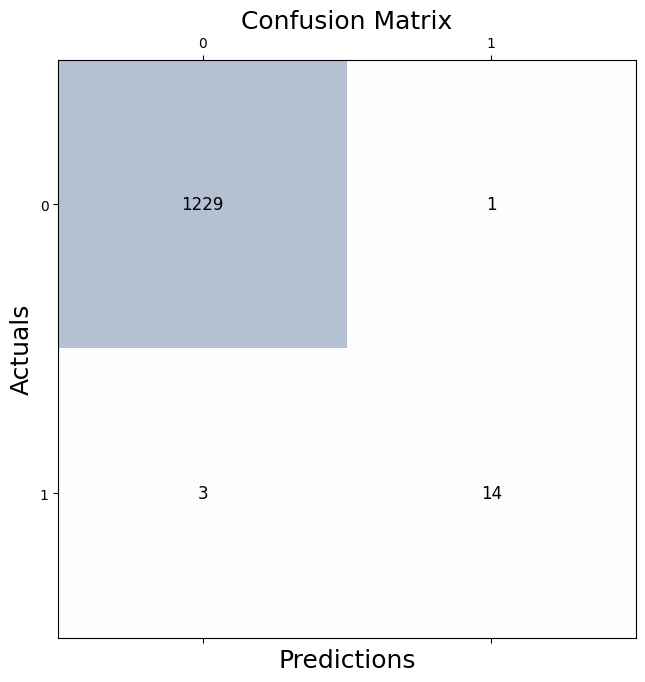

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1230
           1       0.93      0.82      0.88        17

    accuracy                           1.00      1247
   macro avg       0.97      0.91      0.94      1247
weighted avg       1.00      1.00      1.00      1247



In [20]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import f1_score, make_scorer, confusion_matrix, classification_report
import matplotlib.pyplot as plt

# Create a Gradient Boosting model object
model = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)

# Train the model on the training data
model.fit(X, y)

# Make predictions on the test data
y_hat = model.predict(testX)

# Evaluate the model
accuracy = model.score(testX, testY)
print('Accuracy: ', accuracy)

# Setup to get F-score and Cross-validation scores
scorerVar = make_scorer(f1_score, pos_label=1)

scores = cross_val_score(model, inputs, target, cv=StratifiedKFold(n_splits=5, shuffle=True), scoring=scorerVar)
print('F1 Scores: ', scores)
print('F1 Scores Mean: ', scores.mean())
print('F1 Scores STD: ', scores.std())

# Confusion matrix
conf_matrix = confusion_matrix(testY, y_hat)
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i, s=conf_matrix[i, j], va='center', ha='center', size='large')

plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

# Classification report
print(classification_report(testY, y_hat))


### 2-AdaBoost

/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/.venv/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Accuracy:  0.9959903769045709


/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/.venv/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/.venv/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/.venv/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/.venv/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:519

F1 Scores:  [0.93333333 0.85714286 0.85714286 0.85714286 0.85714286]
F1 Scores Mean:  0.8723809523809523
F1 Scores STD:  0.030476190476190504


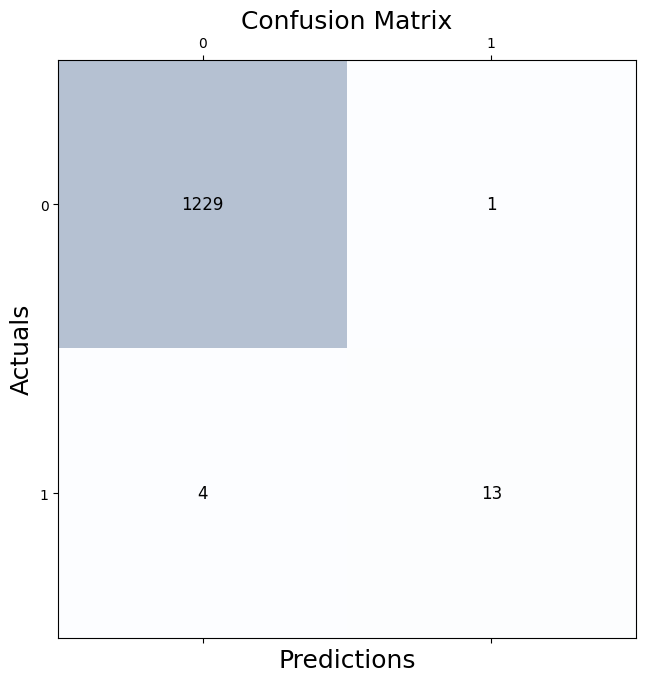

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1230
           1       0.93      0.76      0.84        17

    accuracy                           1.00      1247
   macro avg       0.96      0.88      0.92      1247
weighted avg       1.00      1.00      1.00      1247



In [21]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import f1_score, make_scorer, confusion_matrix, classification_report
import matplotlib.pyplot as plt

# Create an AdaBoost model object
model = AdaBoostClassifier(n_estimators=50, learning_rate=1.0, random_state=0)

# Train the model on the training data
model.fit(X, y)

# Make predictions on the test data
y_hat = model.predict(testX)

# Evaluate the model
accuracy = model.score(testX, testY)
print('Accuracy: ', accuracy)

# Setup to get F-score and Cross-validation scores
scorerVar = make_scorer(f1_score, pos_label=1)

scores = cross_val_score(model, inputs, target, cv=StratifiedKFold(n_splits=5, shuffle=True), scoring=scorerVar)
print('F1 Scores: ', scores)
print('F1 Scores Mean: ', scores.mean())
print('F1 Scores STD: ', scores.std())

# Confusion matrix
conf_matrix = confusion_matrix(testY, y_hat)
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i, s=conf_matrix[i, j], va='center', ha='center', size='large')

plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

# Classification report
print(classification_report(testY, y_hat))


### 3-Random Forests

Accuracy:  0.9911788291900562
F1 Scores:  [0.54545455 0.54545455 0.54545455 0.61538462 0.4       ]
F1 Scores Mean:  0.5303496503496503
F1 Scores STD:  0.07057825471512238


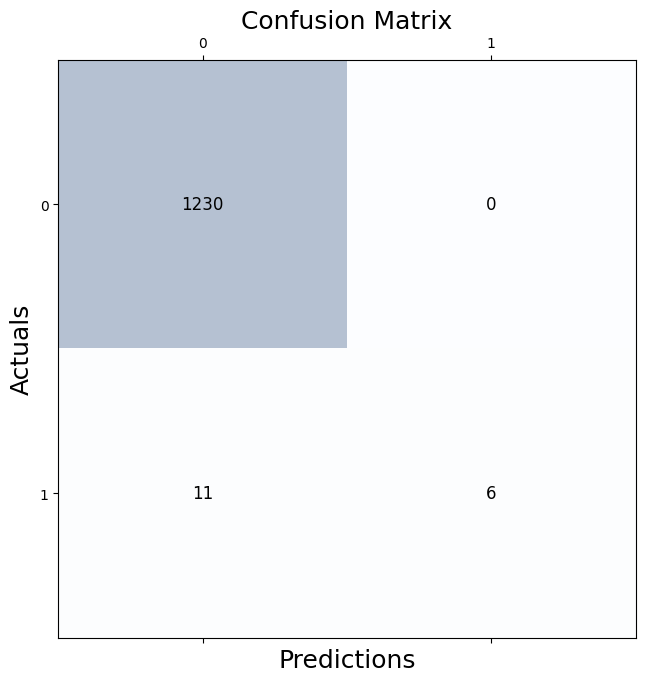

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1230
           1       1.00      0.35      0.52        17

    accuracy                           0.99      1247
   macro avg       1.00      0.68      0.76      1247
weighted avg       0.99      0.99      0.99      1247



In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import f1_score, make_scorer, confusion_matrix, classification_report
import matplotlib.pyplot as plt

# Create a Random Forest model object
model = RandomForestClassifier(n_estimators=100, random_state=0)

# Train the model on the training data
model.fit(X, y)

# Make predictions on the test data
y_hat = model.predict(testX)

# Evaluate the model
accuracy = model.score(testX, testY)
print('Accuracy: ', accuracy)

# Setup to get F-score and Cross-validation scores
scorerVar = make_scorer(f1_score, pos_label=1)

scores = cross_val_score(model, inputs, target, cv=StratifiedKFold(n_splits=5, shuffle=True), scoring=scorerVar)
print('F1 Scores: ', scores)
print('F1 Scores Mean: ', scores.mean())
print('F1 Scores STD: ', scores.std())

# Confusion matrix
conf_matrix = confusion_matrix(testY, y_hat)
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i, s=conf_matrix[i, j], va='center', ha='center', size='large')

plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

# Classification report
print(classification_report(testY, y_hat))


# ML Models (with PCA Dimensionality Reduction)

## Setup

In [23]:
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import confusion_matrix, f1_score, classification_report, make_scorer
import matplotlib.pyplot as plt
import sklearn as sk

### Train/Test Split

In [24]:
# Split the data
inputs = complete_data_transformed.drop(columns=['risk', 'geometry'])
target = complete_data_transformed['risk']
trainX, testX, trainY, testY = train_test_split(inputs, target, test_size=0.3, random_state=42)

### PCA

In [25]:
# Define PCA with 6 components
pca = PCA(n_components=2)

## Single Classifiers

### 1-Logistic Regression

Explained variance ratio: [0.99882973 0.0011699 ]
Total explained variance ratio: 0.9999996275250741
Accuracy:  0.9879711307137129
F1 Scores:  [0. 0. 0. 0. 0.]
F1 Scores Mean: 0.0
F1 Scores STD: 0.0


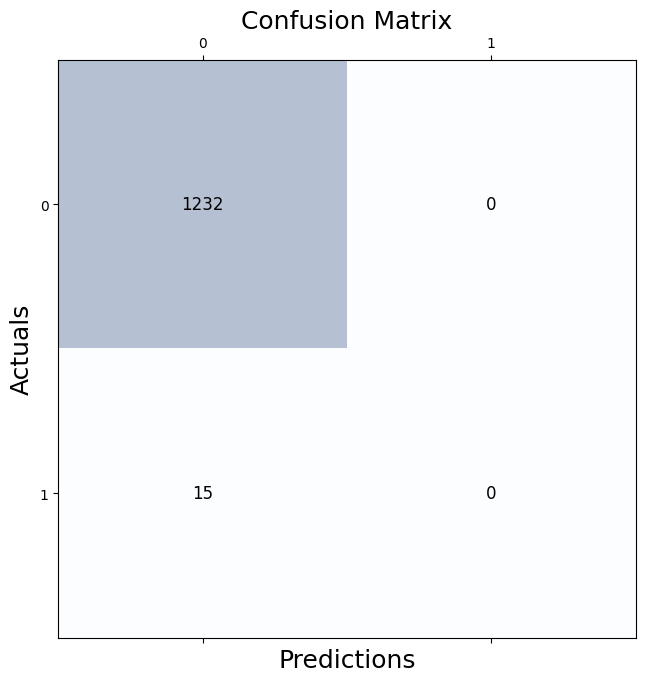

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1232
           1       0.00      0.00      0.00        15

    accuracy                           0.99      1247
   macro avg       0.49      0.50      0.50      1247
weighted avg       0.98      0.99      0.98      1247



/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to cont

In [26]:
# Create a logistic regression model
logistic = LogisticRegression(max_iter=1000)

# Create a pipeline
model = Pipeline(steps=[('pca', pca), ('logistic', logistic)])

# Train the model
model.fit(trainX, trainY)

# Print the explained variance
print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Total explained variance ratio:", sum(pca.explained_variance_ratio_))

# Predictions
y_hat = model.predict(testX)

# Evaluate the model
accuracy = model.score(testX, testY)
print('Accuracy: ', accuracy)

# Setup to get F-score and cross-validation scores
scorerVar = make_scorer(f1_score, pos_label=1)
scores = cross_val_score(model, inputs, target, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), scoring=scorerVar)
print('F1 Scores: ', scores)
print('F1 Scores Mean:', scores.mean())
print('F1 Scores STD:', scores.std())

# Confusion matrix
conf_matrix = confusion_matrix(testY, y_hat)
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i, s=conf_matrix[i, j], va='center', ha='center', size='large')

plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

# Classification report
print(classification_report(testY, y_hat))

### 2-K-Nearest Neighbor

Accuracy:  0.9895749799518845
F1 Scores:  [0.4        0.4        0.5        0.30769231 0.33333333]
F1 Scores Mean: 0.3882051282051282
F1 Scores STD: 0.0667376348102459


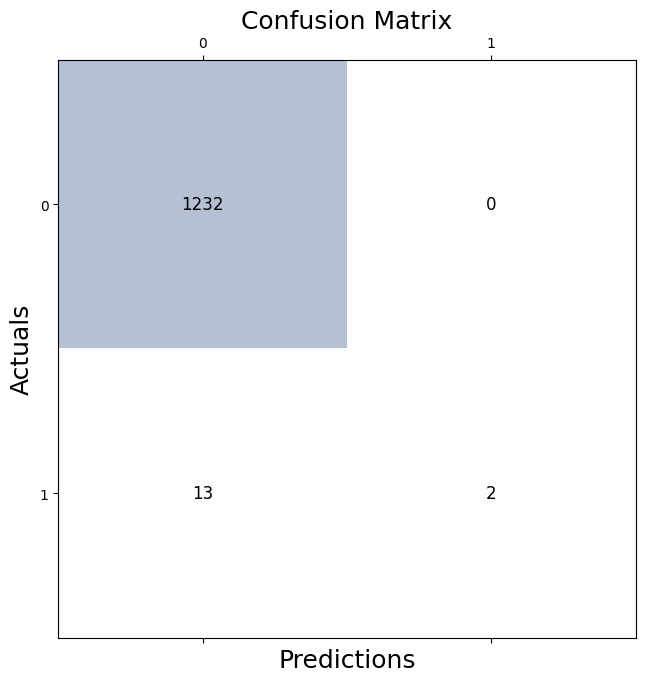

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1232
           1       1.00      0.13      0.24        15

    accuracy                           0.99      1247
   macro avg       0.99      0.57      0.62      1247
weighted avg       0.99      0.99      0.99      1247



In [27]:
# Create a K-Nearest Neighbors model
knn = KNeighborsClassifier(n_neighbors=5)

# Create a pipeline
model = Pipeline(steps=[('pca', pca), ('knn', knn)])

# Train the model
model.fit(trainX, trainY)

# Predictions
y_hat = model.predict(testX)

# Evaluate the model
accuracy = model.score(testX, testY)
print('Accuracy: ', accuracy)

# Setup to get F-score and cross-validation scores
scorerVar = make_scorer(f1_score, pos_label=1)
scores = cross_val_score(model, inputs, target, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), scoring=scorerVar)
print('F1 Scores: ', scores)
print('F1 Scores Mean:', scores.mean())
print('F1 Scores STD:', scores.std())

# Confusion matrix
conf_matrix = confusion_matrix(testY, y_hat)
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i, s=conf_matrix[i, j], va='center', ha='center', size='large')

plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

# Classification report
print(classification_report(testY, y_hat))

### 3-Support Vector Machine

Accuracy:  0.9879711307137129
F1 Scores:  [0. 0. 0. 0. 0.]
F1 Scores Mean: 0.0
F1 Scores STD: 0.0


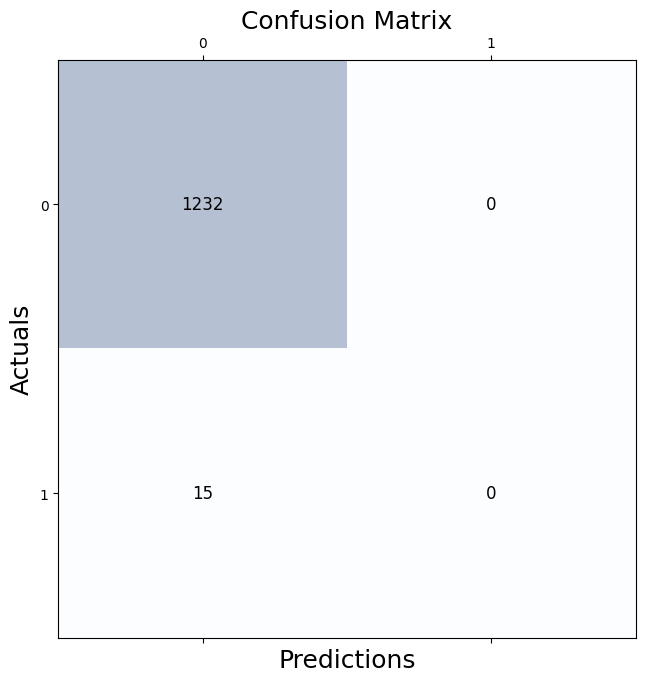

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1232
           1       0.00      0.00      0.00        15

    accuracy                           0.99      1247
   macro avg       0.49      0.50      0.50      1247
weighted avg       0.98      0.99      0.98      1247



/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to cont

In [28]:
# Create a Support Vector Machine model
svm = SVC(kernel='rbf', C=1.0)

# Create a pipeline
model = Pipeline(steps=[('pca', pca), ('svm', svm)])

# Train the model
model.fit(trainX, trainY)

# Predictions
y_hat = model.predict(testX)

# Evaluate the model
accuracy = model.score(testX, testY)
print('Accuracy: ', accuracy)

# Setup to get F-score and cross-validation scores
scorerVar = make_scorer(f1_score, pos_label=1)
scores = cross_val_score(model, inputs, target, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), scoring=scorerVar)
print('F1 Scores: ', scores)
print('F1 Scores Mean:', scores.mean())
print('F1 Scores STD:', scores.std())

# Confusion matrix
conf_matrix = confusion_matrix(testY, y_hat)
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i, s=conf_matrix[i, j], va='center', ha='center', size='large')

plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

# Classification report
print(classification_report(testY, y_hat))


## Ensemble Classifiers

### 1-Gradient Boosting

Accuracy:  0.9879711307137129
F1 Scores:  [0.13793103 0.16666667 0.22222222 0.14285714 0.12903226]
F1 Scores Mean: 0.1597418648586613
F1 Scores STD: 0.03363222872354552


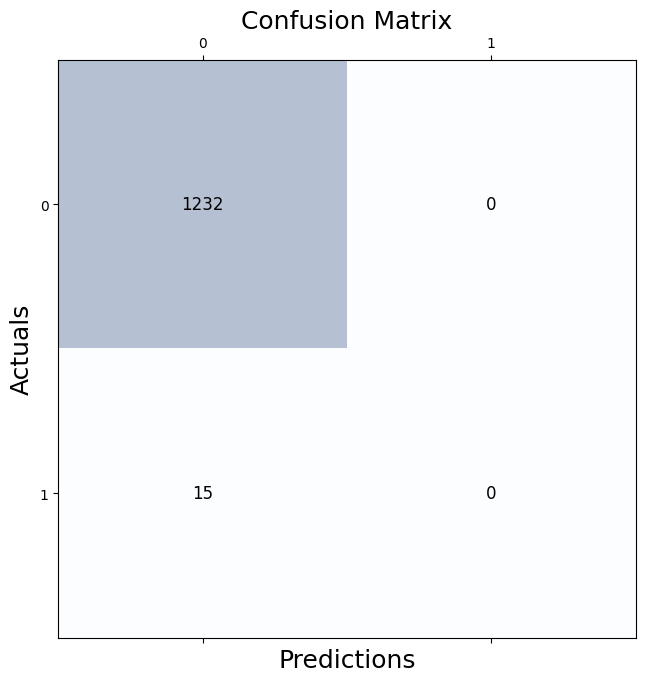

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1232
           1       0.00      0.00      0.00        15

    accuracy                           0.99      1247
   macro avg       0.49      0.50      0.50      1247
weighted avg       0.98      0.99      0.98      1247



/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to cont

In [29]:
# Create a Gradient Boosting classifier
gbdt = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0)

# Create a pipeline
model = Pipeline(steps=[('pca', pca), ('gbdt', gbdt)])

# Train the model
model.fit(trainX, trainY)

# Predictions
y_hat = model.predict(testX)

# Evaluate the model
accuracy = model.score(testX, testY)
print('Accuracy: ', accuracy)

# Setup to get F-score and cross-validation scores
scorerVar = make_scorer(f1_score, pos_label=1)
scores = cross_val_score(model, inputs, target, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), scoring=scorerVar)
print('F1 Scores: ', scores)
print('F1 Scores Mean:', scores.mean())
print('F1 Scores STD:', scores.std())

# Confusion matrix
conf_matrix = confusion_matrix(testY, y_hat)
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i, s=conf_matrix[i, j], va='center', ha='center', size='large')

plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

# Classification report
print(classification_report(testY, y_hat))


### 2-AdaBoost

/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/.venv/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Accuracy:  0.9879711307137129


/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/.venv/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/.venv/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/.venv/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/.venv/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:519

F1 Scores:  [0.         0.         0.         0.30769231 0.        ]
F1 Scores Mean: 0.06153846153846154
F1 Scores STD: 0.12307692307692308


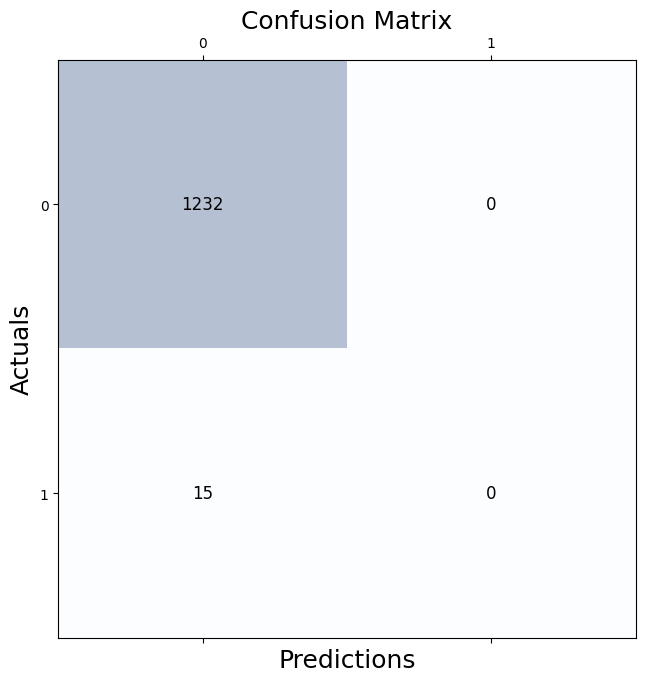

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1232
           1       0.00      0.00      0.00        15

    accuracy                           0.99      1247
   macro avg       0.49      0.50      0.50      1247
weighted avg       0.98      0.99      0.98      1247



/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/ichittumuri/Desktop/MINES/COGCC-Risk-Analysis/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to cont

In [30]:
# Create an AdaBoost classifier
# The default base estimator is DecisionTreeClassifier initialized with max_depth=1
adaboost = AdaBoostClassifier(n_estimators=50, learning_rate=1.0, random_state=0)

# Create a pipeline
model = Pipeline(steps=[('pca', pca), ('adaboost', adaboost)])

# Train the model
model.fit(trainX, trainY)

# Predictions
y_hat = model.predict(testX)

# Evaluate the model
accuracy = model.score(testX, testY)
print('Accuracy: ', accuracy)

# Setup to get F-score and cross-validation scores
scorerVar = make_scorer(f1_score, pos_label=1)
scores = cross_val_score(model, inputs, target, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), scoring=scorerVar)
print('F1 Scores: ', scores)
print('F1 Scores Mean:', scores.mean())
print('F1 Scores STD:', scores.std())

# Confusion matrix
conf_matrix = confusion_matrix(testY, y_hat)
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i, s=conf_matrix[i, j], va='center', ha='center', size='large')

plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

# Classification report
print(classification_report(testY, y_hat))


### 3-Random Forests

Accuracy:  0.9863672814755413
F1 Scores:  [0.46153846 0.30769231 0.4        0.375      0.4       ]
F1 Scores Mean: 0.3888461538461539
F1 Scores STD: 0.04961985668575428


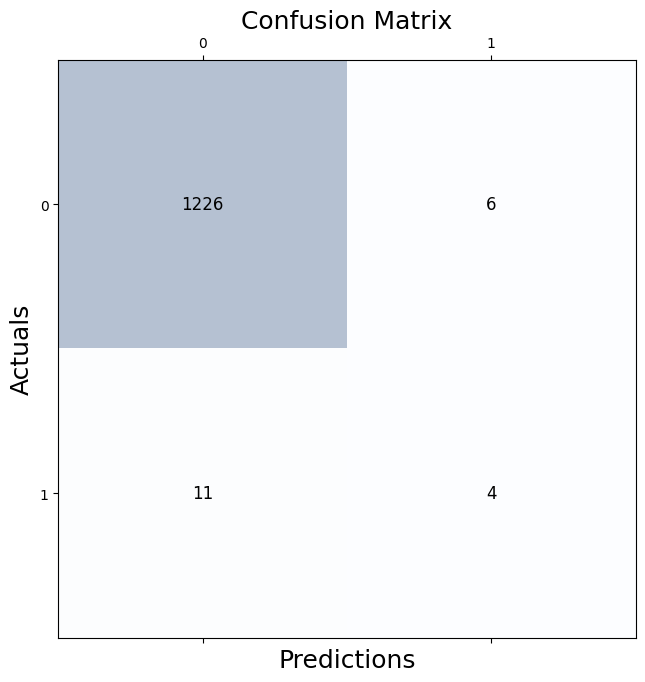

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1232
           1       0.40      0.27      0.32        15

    accuracy                           0.99      1247
   macro avg       0.70      0.63      0.66      1247
weighted avg       0.98      0.99      0.99      1247



In [31]:
# Create a Random Forest classifier
random_forest = RandomForestClassifier(n_estimators=100, random_state=0)

# Create a pipeline
model = Pipeline(steps=[('pca', pca), ('random_forest', random_forest)])

# Train the model
model.fit(trainX, trainY)

# Predictions
y_hat = model.predict(testX)

# Evaluate the model
accuracy = model.score(testX, testY)
print('Accuracy: ', accuracy)

# Setup to get F-score and cross-validation scores
scorerVar = make_scorer(f1_score, pos_label=1)
scores = cross_val_score(model, inputs, target, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), scoring=scorerVar)
print('F1 Scores: ', scores)
print('F1 Scores Mean:', scores.mean())
print('F1 Scores STD:', scores.std())

# Confusion matrix
conf_matrix = confusion_matrix(testY, y_hat)
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i, s=conf_matrix[i, j], va='center', ha='center', size='large')

plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

# Classification report
print(classification_report(testY, y_hat))


# ML Models (Other Dimensionality Reduction Methods) [Future Work]